# Sensitivity Analysis

- one way to determine which features contribute to an output prediction is via sensitivity analysis, i.e. the gradient of the output with respect to the input features
- this tells us how much the output is expected to change when that input feature changes
- Depeweg et al. (2017) studies this approach for uncertainty in the report titled "Sensitivity Analysis for Predictive Uncertainty in Bayesian Neural Networks"
- This notebook applies that approach to images. With images, this approach does not work well because it allows the sensitivity of each pixel to vary irrespective of neighboring pixels. For images, we would like a smoother saliency map. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from numpy import ma
from keras.layers import Input
import tensorflow as tf
from toolbox import load_dataset

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [3]:
dataset = 'mnist'
file_name = '../../models/bbalpha/keras/saved_models/{}-cnn-alpha0.5-run1/model-test.h5'.format(dataset)
nb_test = 100
model = load_model(file_name)
_, _, test = load_dataset.load_mnist(flatten=False, channels_first=False)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
input_shape = model.layers[0].input_shape[1:] # remove None dimension


In [5]:
tf.trainable_variables()

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(4608, 100) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>]

In [6]:
x = tf.placeholder(tf.float32, shape=(None,) + input_shape)

In [7]:
def MC_dropout(model, x):
    pred_mc = model(x) # N x K x D
    n_mc = pred_mc.shape[1]
    if n_mc > 1:
        pred = tf.reduce_mean(pred_mc, 1)
    else:
        pred = pred_mc
    return pred_mc, pred

In [8]:
def tf_log2(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(2, dtype=numerator.dtype))
    return numerator / denominator

In [9]:
pred_mc, predictions = MC_dropout(model, x)

In [10]:
plogp = predictions * tf_log2(tf.clip_by_value(predictions,1e-10,1.0))
predictive_uncertainty = - tf.reduce_sum(plogp, axis=1)
predictive_uncertainty

<tf.Tensor 'Neg:0' shape=(?,) dtype=float32>

In [11]:
plogp_mc = pred_mc * tf_log2(tf.clip_by_value(pred_mc,1e-10,1.0))
aleatoric_uncertainty = - 1 / nb_test * tf.reduce_sum(plogp_mc, axis=(1,2))
aleatoric_uncertainty

<tf.Tensor 'mul_2:0' shape=(?,) dtype=float32>

In [12]:
epistemic_uncertainty = predictive_uncertainty - aleatoric_uncertainty
epistemic_uncertainty

<tf.Tensor 'sub:0' shape=(?,) dtype=float32>

In [13]:
predictive_grad, = tf.gradients(predictive_uncertainty, x)
predictive_grad = tf.stop_gradient(predictive_grad)

In [14]:
epistemic_grad, = tf.gradients(epistemic_uncertainty, x)
epistemic_grad = tf.stop_gradient(epistemic_grad)

In [15]:
aleatoric_grad, = tf.gradients(aleatoric_uncertainty, x)
aleatoric_grad = tf.stop_gradient(aleatoric_grad)

In [16]:
[p_grad, a_grad, e_grad, preds] = sess.run([predictive_grad, aleatoric_grad, epistemic_grad, predictions], feed_dict={x: test[0]})

0


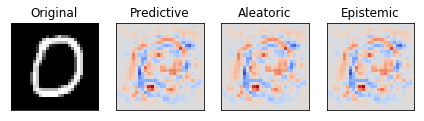

In [26]:
# plot test data
ind = 10
print(np.argmax(preds[ind, :]))
f, axes = plt.subplots(1, 4)
axes[0].imshow(test[0][ind, :, :, 0], cmap='gray')
im1 = axes[1].imshow(p_grad[ind, :, :, 0], cmap='coolwarm')
im2 = axes[2].imshow(a_grad[ind, :, :, 0], cmap='coolwarm')
im3 = axes[3].imshow(e_grad[ind, :, :, 0], cmap='coolwarm')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title('Original')
axes[1].set_title('Predictive')
axes[2].set_title('Aleatoric')
axes[3].set_title('Epistemic')
f.tight_layout()
f.savefig('sensitivity_{}_{}.png'.format(dataset, ind), dpi=600)